In [1]:
import pandas as pd
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
np.random.seed(4684)

In [2]:
data = pd.read_csv('emails.csv')

In [3]:
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
0,8,short_email,generic,9,Thursday,US,3,0
1,33,long_email,personalized,6,Monday,US,0,0
2,46,short_email,generic,14,Tuesday,US,3,0
3,49,long_email,personalized,11,Thursday,US,10,0
4,65,short_email,generic,8,Wednesday,UK,3,0


In [4]:
#prepare the data for the model
data = pd.get_dummies(data, drop_first=True)
train_cols = data.drop('clicked', axis=1)

In [5]:
#Build the model. Here we just care about showing how to extract insights. Optimizing the model is beyond the scope of this section. Only thing we do beside default options is (a) increasing the weight of minority class via class_weight to make sure the trees split on something and (b) increase the number of trees
rf = RandomForestClassifier(class_weight={0:0.05,1:0.95}, n_estimators=50)
rf.fit(train_cols, data['clicked'])

RandomForestClassifier(class_weight={0: 0.05, 1: 0.95}, n_estimators=50)

In [6]:
#Let's build the PDP for the variable email_version. 
#It is going to be fast since it has just two unique values. But the entire procedure would be exactly the same for any other categorical or numerical variable, would just be more computationally expensive
pdp_version = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols), feature='email_version_personalized')

In [7]:
#Let's get the actual values.
print(pdp_version.pdp)

[0.01413267 0.02597619]


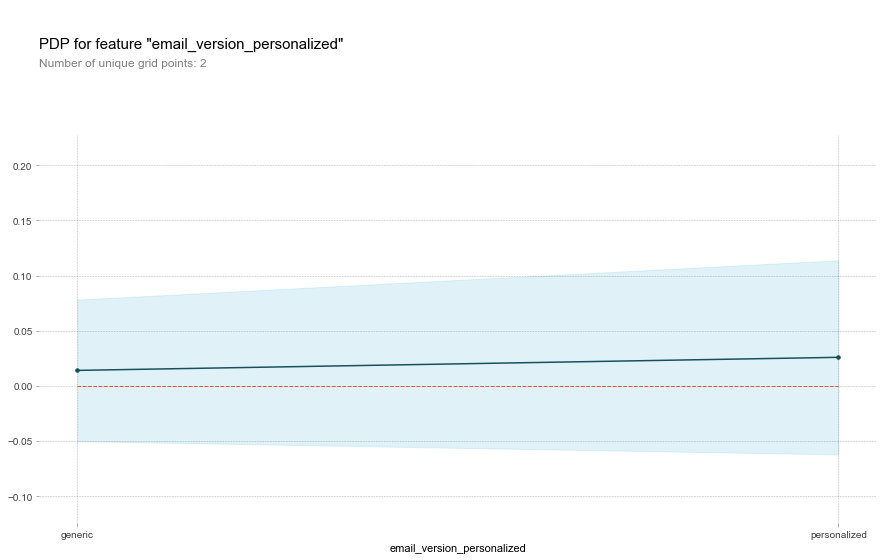

In [8]:
fig, axes = pdp.pdp_plot(pdp_version, 'email_version_personalized', center=False)
_ = axes['pdp_ax'].set_xticklabels(['generic', 'personalized'])
plt.show()

---

### Creating a PDP from scratch

In [10]:
#Create empty data frame where I store all predictions. Each column will be a prediction for a given event (so we have 99950 of them) and each row a unique element of email_version (so 2)
pred_df = pd.DataFrame(index=range(data['email_version_personalized'].nunique()), columns=range(data.shape[0]))
  
#Start a for loop for each unique value of email_version_personalized. Just two here
for i in range(data['email_version_personalized'].nunique()):
    #replace in the training set all values of email version with a fixed one
    tmp = data.assign(email_version_personalized = i) #assign value of i to email_version_personalized column
    #get the predictions as probabilities 
    predictions = rf.predict_proba(tmp.drop('clicked', axis=1))
    #pred_df is our datasets with the partial predictions for each event. 
    #Each column is one of the events that were computed via predict_proba. The first row is the prediction when we fixed the value of email_version as generic for that event. The second row is the prediction for the the same event after changing the value of email_version to personalized  
    pred_df.iloc[[i], :]=[x[1] for x in predictions]
  
#Let's now average those values to get the plots. Intuitively, that makes sense. The only difference we see in those predictions is given by the fact that we change the value of email version. And the average is a way to understand the overall impact across all data
pdp_values = pred_df.mean(axis=1)
#prettier indices
pdp_values.rename(index={0:'generic', 1:'personalized'},inplace=True)
  
#Finally let's compare our results with pdpbox values, which are the ones in the plot above
output_table = pd.DataFrame(dict(own_pdp = pdp_values, python_pdp_library = pdp_version.pdp))
print(output_table)
  
#They perfectly match! Now you know how pdp are calculated!

               own_pdp  python_pdp_library
generic       0.014133            0.014133
personalized  0.025976            0.025976


In [ ]:
predictions[0]

In [ ]:
range(data['email_version_personalized'].nunique())

In [ ]:
data.shape

In [ ]:
data.shape[0] # returns the number of row

In [ ]:
pred_df # contains the predictions for each row in the dataset for each possible value of email_version_personalized

In [ ]:
data.assign(email_version_personalized = 1) # returns a new Dataframe with email_version_personalized values updated to 1

In [ ]:
pdp_values

---

### Creating a feature importance plot

In [ ]:
#Same steps as in the previous section to get the dataset ready
import pandas 
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
pandas.set_option('display.max_columns', 10)
rcParams.update({'figure.autolayout': True})
  
np.random.seed(4684)
data = pandas.read_csv('emails.csv')
  
#prepare the data for the model
data_dummy = pandas.get_dummies(data, drop_first=True)
train_cols = data_dummy.drop('clicked', axis=1)
  
#build the model. Again, here we just care about showing how to extract insights. Optimizing the model is beyond the scope of this section. Only thing we do beside default options is increasing the weight of minority class via classwt to make sure the trees split on something and choose 50 as tree number
rf = RandomForestClassifier(class_weight={0:0.05,1:0.95}, n_estimators=50)
rf.fit(train_cols, data_dummy['clicked'])
  
#estimate variable importance
feat_importances = pandas.Series(rf.feature_importances_, index=train_cols.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh')
plt.show()

--- 

### Plot all variables, grouping dummy variables together than come from the same categorical variable

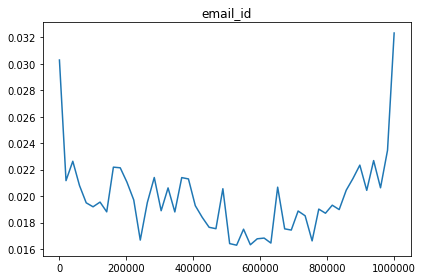

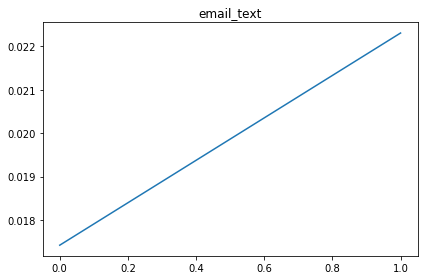

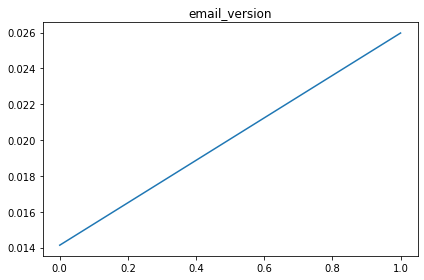

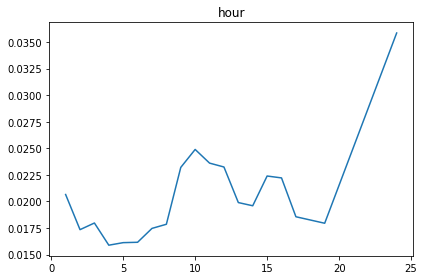

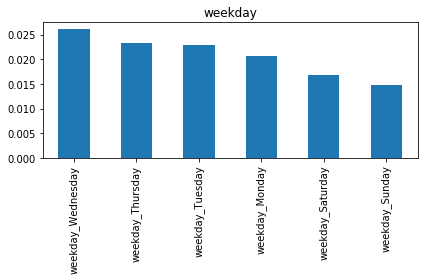

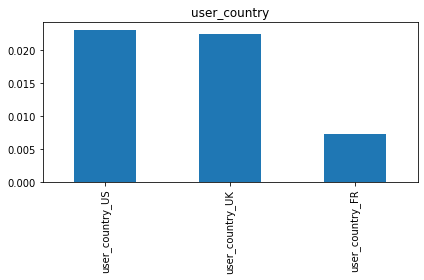

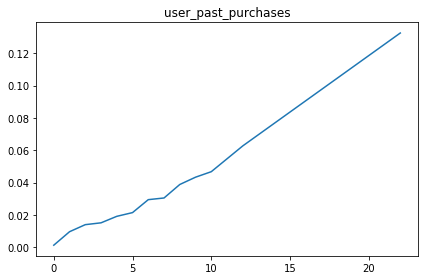

In [13]:
#Let's plot all of them. Note that pdpbox allows to group together dummy variables coming from the same categorical variable. For this we need to get the original variable names.
feat_original = data.columns.drop('clicked')
  
#plot all variables with a for loop. If a variable is categorical make sure to plot all levels together.
for i in range(len(feat_original)):
    #get all variables that include the name in feat_original. So, if it is numeric, just take that variable. If it is categorical, take all dummies belonging to the same categorical variable. Since for dummies their name is variable_level, this is easy. Just pick all variables that start with the original variable name. I.e. to get all weekday dummies (weekday_Monday, weekday_Tuesday, etc.), we just look for all variables starting with "weekday"
    #variables to plot
    plot_variable = [e for e in list(train_cols) if e.startswith(feat_original[i])]
      
    #numeric variables or dummy with just 1 level
    if len(plot_variable) == 1:
        # build pdp
       pdp_iso = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols), feature=plot_variable[0], num_grid_points=50)
       pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
       #pdpbox has several options if you want to use their built-in plots. I personally prefer just using .plot. It is totally subjective obviously.
       pdp_dataset.plot(title=feat_original[i])
       plt.show()
         
    #categorical variables with several levels
    else:
       pdp_iso = pdp.pdp_isolate( model=rf, dataset=train_cols, model_features=list(train_cols),  feature=plot_variable, num_grid_points=50)
       pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
       pdp_dataset.sort_values(ascending=False).plot(kind='bar', title=feat_original[i])
       plt.show()
    plt.close()

In [42]:
feat_original

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases'], dtype='object')

In [43]:
[e for e in list(train_cols) if e.startswith(feat_original[2])]

['email_version_personalized']